# Pharmaceutical Text Review

### Background

The intent of this excercise is ultimately to predict the review score of a drug review based on the user's freeform review. While going through this process, I will also conduct a sentiment analysis (reviewing both the true sentiment of the review as well as the user-prescribed sentiment). The data is provided already split in 75/25 train/test split

In addition, the following data dictionary was provided with the dataset (with formatting edits):

#### Attribute Information:
1. drugName (categorical): name of drug 
2. condition (categorical): name of condition 
3. review (text): patient review 
4. rating (numerical): 10 star patient rating 
5. date (date): date of review entry 
6. usefulCount (numerical): number of users who found review useful


Citation to the original data is below:
Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125. DOI: [Web Link](https://doi.org/10.1145/3194658.3194677)

### Import Modules

In [57]:
import pandas as pd
import numpy as np
import re
import nltk
from afinn import Afinn
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from spellchecker import SpellChecker
import torch
import transformers as ppb # pytorch transformers
# nltk.download('vader_lexicon')
# nltk.download('punkt')
%matplotlib inline

### Import Data

In [9]:
## Import the train and test data, assign an ID, and join them for easier processing

train = pd.read_csv('../data/drugsCom_raw/drugsComTrain_raw.tsv', delimiter = '\t', 
                    index_col = 0).reset_index(drop = True)
train['ID'] = 'train'


test = pd.read_csv('../data/drugsCom_raw/drugsComTrain_raw.tsv', delimiter = '\t', 
                   index_col = 0).reset_index(drop = True)
test['ID'] = 'test'

fullDat = train.append(test).reset_index(drop = True)

In [10]:
fullDat.head()

,drugName,condition,review,rating,date,usefulCount,ID
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,train
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,train
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,train
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,train
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,train


In [13]:
fullDat.rating.value_counts()

10.0    101978
9.0      55062
1.0      43238
8.0      37780
7.0      18912
5.0      16026
2.0      13862
3.0      13026
6.0      12686
4.0      10024
Name: rating, dtype: int64

In [16]:
## Ratings are all intergers so converting away from the float they currently are
fullDat.rating = fullDat.rating.astype('int')

In [17]:
fullDat.head()

,drugName,condition,review,rating,date,usefulCount,ID
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,"May 20, 2012",27,train
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,"April 27, 2010",192,train
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,"December 14, 2009",17,train
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,"November 3, 2015",10,train
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,"November 27, 2016",37,train


### Clean Text

The review's provided are not very clean with formatting provided for non-alphanumeric characters. Rather than using regex, manually removing to set to obtain a correct word. Rather than replace `I&#039;m` to `Im` with regex, manually replacing to `I'm`.

In [18]:
## Loop over each review and, if the review has a string that matches the regex pattern, add to set for review
## Regex pattern looks for &, then any number of characters up to a ;

fixCount = {}

find = re.compile('(&.*?;)')

for index, row in fullDat.iterrows():
    regexOut = find.findall(row['review'])
    for item in regexOut:
        fixCount[item] = fixCount.get(item, 0) + 1

In [19]:
fixCount

{'&#039;': 524830,
 '&amp;': 26094,
 '&quot;': 42524,
 '&rsquo;': 6058,
 '&gt;': 324,
 '&times;': 54,
 '&egrave;': 16,
 '&bull;': 104,
 '&euro;': 24,
 '&lt;': 216,
 '&pound;': 56,
 '&nbsp;': 28,
 '&mdash;': 132,
 '&lsquo;': 60,
 '&ldquo;': 232,
 '&rdquo;': 234,
 '&deg;': 20,
 '&ndash;': 96,
 '&macr;': 16,
 '&eacute;': 222,
 '&ouml;': 10,
 '&frac12;': 30,
 '&reg;': 10,
 '&divide;': 4,
 '&hellip;': 136,
 '&acute;': 46,
 '&ge;': 2,
 '&frac34;': 4,
 '&ntilde;': 22,
 '&oacute;': 8,
 '&lrm;': 8,
 '&micro;': 2,
 '&frac14;': 4,
 '&agrave;': 10,
 '&Prime;': 4,
 '&igrave;': 2,
 '&ecirc;': 2,
 '&ocirc;': 2,
 '&Iacute;': 2,
 '&iacute;': 2,
 '&acirc;': 2,
 '&aacute;': 2,
 '&oslash;': 4,
 '&iquest;': 2}

In [20]:
toChange = {'&#039;': "'",
            '&bull;': '',
            '&amp;': 'and',
            '&quot;': "'",
            '&rsquo;': "'",
            '&gt;': '>',
            '&lt;': '<',
            '&times;': '',
            '&egrave;': 'e',
            '&euro;': '',
            '&pound;': '',
            '&nbsp;': '',
            '&mdash;': '-',
            '&lsquo': "'",
            '&ldquo': "'",
            '&rdquo': "'",
            '&deg;': '',
            '&ndash': '-',
            '&macr;': '',
            '&eacute;': 'e',
            '&ouml;': 'o',
            '&frac12;': '1/2',
            '&reg;': '',
            '&divide;': '/',
            '&hellip;': '',
            '&acute;': '',
            '&ge;': '>=',
            '&frac34;': '3/4',
            '&ntilde;': 'n',
            '&oacute;': 'o',
            '&lrm;': '',
            '&micro;': '',
            '&frac14;': '1/4',
            '&agrave;': 'a',
            '&Prime;': "'",
            '&igrave;': 'i',
            '&ecirc;': 'e',
            '&ocirc;': 'o',
            '&Iacute;': 'I',
            '&iacute;': 'i',
            '&acirc;': 'a',
            '&aacute;': 'a',
            '&oslash;': 'o',
            '&iquest;': ''
             }

for changeFrom, changeTo in toChange.items():
    fullDat['review'].replace(to_replace = changeFrom, value = changeTo, inplace = True,regex = True) 

In [21]:
## Rerun the regex to see if the fix missed anything
fixCount = {}

find = re.compile('(&.*?;)')

for index, row in fullDat.iterrows():
    regexOut = find.findall(row['review'])
    for item in regexOut:
        fixCount[item] = fixCount.get(item, 0) + 1
        
fixCount

{}

In [22]:
## Remove the beginning and ending quotes
fullDat['review'] = fullDat['review'].str[1:-1]
fullDat.head()

,drugName,condition,review,rating,date,usefulCount,ID
0,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,"May 20, 2012",27,train
1,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,"April 27, 2010",192,train
2,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,"December 14, 2009",17,train
3,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8,"November 3, 2015",10,train
4,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,"November 27, 2016",37,train


### Run sentiment analysis

For this section, I will be using `VADER`. The implementation of which in Python is heavily derived from this source: https://programminghistorian.org/en/lessons/sentiment-analysis

Additionally testing sentiments traditionally used in R with `AFINN`.

In [23]:
## AFINN
afinn = Afinn()
for index, row in fullDat.iterrows():
    fullDat.at[index,'sent_AFINN'] = afinn.score(row['review'])

In [24]:
fullDat.head()

,drugName,condition,review,rating,date,usefulCount,ID,sent_AFINN
0,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,"May 20, 2012",27,train,-1.0
1,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,"April 27, 2010",192,train,6.0
2,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,"December 14, 2009",17,train,1.0
3,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8,"November 3, 2015",10,train,5.0
4,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,"November 27, 2016",37,train,5.0


In [25]:
## VADER
sid = SentimentIntensityAnalyzer()
for index, row in fullDat.iterrows():
    scores = sid.polarity_scores(row['review'])
    fullDat.at[index,'sent_VADER_neg'] = scores['neg']
    fullDat.at[index,'sent_VADER_neu'] = scores['neu']
    fullDat.at[index,'sent_VADER_pos'] = scores['pos']
    fullDat.at[index,'sent_VADER_compound'] = scores['compound']

In [26]:
# fullDat.head()
# fullDat.to_csv('PreppedFullDat.csv')

### Review Sentiment Scores vs. `rating`

In [3]:
# fullDat = pd.read_csv('PreppedFullDat.csv')
# fullDat.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,ID,sent_AFINN,sent_VADER_neg,sent_VADER_neu,sent_VADER_pos,sent_VADER_compound
0,0,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,"May 20, 2012",27,train,-1.0,0.136,0.864,0.000,-0.2960
1,1,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,"April 27, 2010",192,train,6.0,0.018,0.871,0.111,0.9174
2,2,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,"December 14, 2009",17,train,1.0,0.055,0.868,0.077,0.6387
3,3,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8,"November 3, 2015",10,train,5.0,0.027,0.879,0.093,0.7184
4,4,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,"November 27, 2016",37,train,5.0,0.064,0.758,0.178,0.9403


Text(0.5, 1.0, 'VADER Positive')

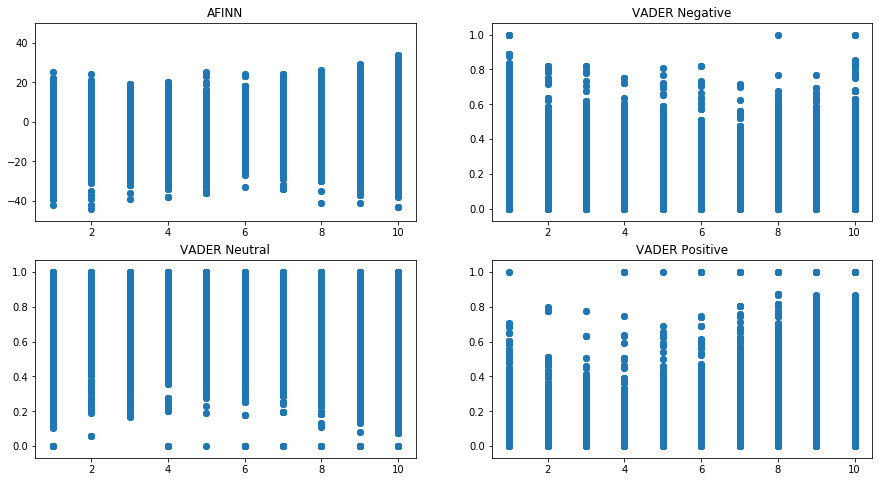

In [29]:
## Plot all four sub-plots of sentiment predictions

fig, axs = plt.subplots(2, 2, figsize = (15,8))
axs[0, 0].scatter(fullDat.rating, fullDat.sent_AFINN)
axs[0, 0].set_title('AFINN')
axs[0, 0].set_ylim(-50, 50)
axs[0, 1].scatter(fullDat.rating, fullDat.sent_VADER_neg)
axs[0, 1].set_title('VADER Negative')
axs[1, 0].scatter(fullDat.rating, fullDat.sent_VADER_neu)
axs[1, 0].set_title('VADER Neutral')
axs[1, 1].scatter(fullDat.rating, fullDat.sent_VADER_pos)
axs[1, 1].set_title('VADER Positive')


There appears to be a rough positive correlations with AFINN and the positive VADER prediction. Running through a true correlation analysis to determine statistical correlation.

As hypothesized from the visuals, there does not appear to be a strong correlation between rating and any of the sentiment figures. Assuming we are capturing sentiment appropriately, it does not appear there is a strong relationships between sentiment and rating.

Reviewed introducing a spell checker but most text looks relatively clean and individual drugs names would need to be removed from spell check.

In [23]:
fullDat[['rating', 'sent_AFINN', 'sent_VADER_neg', 'sent_VADER_neu', 'sent_VADER_pos']].corr()

,rating,sent_AFINN,sent_VADER_neg,sent_VADER_neu,sent_VADER_pos
rating,1.000000,0.284946,-0.268388,-0.020045,0.269879
sent_AFINN,0.284946,1.000000,-0.511012,0.035353,0.428196
sent_VADER_neg,-0.268388,-0.511012,1.000000,-0.562776,-0.260050
sent_VADER_neu,-0.020045,0.035353,-0.562776,1.000000,-0.650012
sent_VADER_pos,0.269879,0.428196,-0.260050,-0.650012,1.000000


### BERT Model

For this exploration, relying on two walkthroughs. The first can be found [here](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) which simply takes DistilBERT pre-trained model and uses pre-trained encoding as features within a model. We will use these features to predict rating and determine correlation. The second, which can be found here, uses transfer learngin on top of DistilBERT (or another hugging transformer algorithm) to generate a model.

In [61]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
tokenized_train = fullDat[fullDat.ID == 'train'].review.apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length = 512, truncation = True)))
tokenized_test = fullDat[fullDat.ID == 'test'].review.apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length = 512, truncation = True)))

In [ ]:
input_ids = torch.tensor(np.array(padded))

with torch.no_grad():
    last_hidden_states = model(input_ids)
    
features = last_hidden_states[0][:,0,:].numpy()